# Based on Yu et al. 2024

In [1]:
import os

import torch

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import numpy.typing as npt
from typing import Callable

current_device = torch.cuda.current_device()
print(torch.cuda.get_device_name(current_device))

NVIDIA GeForce GTX 960


In [2]:
from nn_helper import MyDataset, get_dataset

train_dataset = MyDataset("data/dataset_train_2.csv")
test_dataset = MyDataset("data/dataset_test_2.csv")

In [ ]:
from nn_models import NNYuEtAl

num_sensors = 6
input_size = num_sensors * 2

model = NNYuEtAl(input_size)

batch_size = 8
model.info(batch_size)

Layer (type:depth-idx)                   Output Shape              Param #
NNYuEtAl                                 [8, 2]                    --
├─Conv1d: 1-1                            [8, 20, 10]               80
├─BatchNorm1d: 1-2                       [8, 20, 10]               40
├─MaxPool1d: 1-3                         [8, 20, 5]                --
├─Conv1d: 1-4                            [8, 10, 3]                610
├─BatchNorm1d: 1-5                       [8, 10, 3]                20
├─MaxPool1d: 1-6                         [8, 10, 1]                --
├─Flatten: 1-7                           [8, 10]                   --
├─LSTM: 1-8                              [8, 20]                   2,560
├─LSTM: 1-9                              [8, 20]                   3,360
├─Linear: 1-10                           [8, 2]                    42
Total params: 6,712
Trainable params: 6,712
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.97
Input size (MB): 0.00
Forward/backward p

Loss at epoch 000: train_loss = 1192.932026 / val_loss = 1028.947917
Loss at epoch 010: train_loss = 66.795734 / val_loss = 25.558706
Loss at epoch 020: train_loss = 36.894825 / val_loss = 23.172272
Loss at epoch 030: train_loss = 30.622238 / val_loss = 13.441290
Loss at epoch 040: train_loss = 31.271435 / val_loss = 14.483950
Loss at epoch 050: train_loss = 28.212105 / val_loss = 13.800032
Loss at epoch 060: train_loss = 26.793146 / val_loss = 19.214662
Loss at epoch 070: train_loss = 30.866804 / val_loss = 4.534065
Loss at epoch 080: train_loss = 35.056635 / val_loss = 8.141528
Loss at epoch 090: train_loss = 29.328775 / val_loss = 22.185600
Loss at epoch 100: train_loss = 32.159505 / val_loss = 5.082462
Loss at epoch 110: train_loss = 27.009536 / val_loss = 11.716293
Loss at epoch 120: train_loss = 28.725231 / val_loss = 4.094237
Loss at epoch 130: train_loss = 26.329981 / val_loss = 8.762699
Loss at epoch 140: train_loss = 28.516359 / val_loss = 0.853860
Loss at epoch 150: train_lo

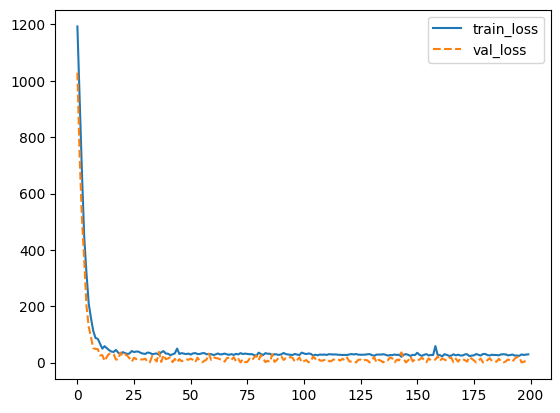

In [4]:
from nn_train import train_model

loss_fn = torch.nn.MSELoss()
optimizer = torch.optim.Adamax(model.parameters(), lr=2e-2)
history = train_model(model, train_dataset, loss_fn, optimizer, current_device, epochs=200, validation_split=0.2, batch_size=batch_size, lambda1=0.02, lambda2=0.01)

# Plot history
plt.figure()

epochs = range(len(history["train_loss"]))
plt_list = [["train_loss", "-"], ["val_loss", "--"]]

for name, style in plt_list:
    plt.plot(epochs, history[name], style, label=name)
plt.legend(loc="best")

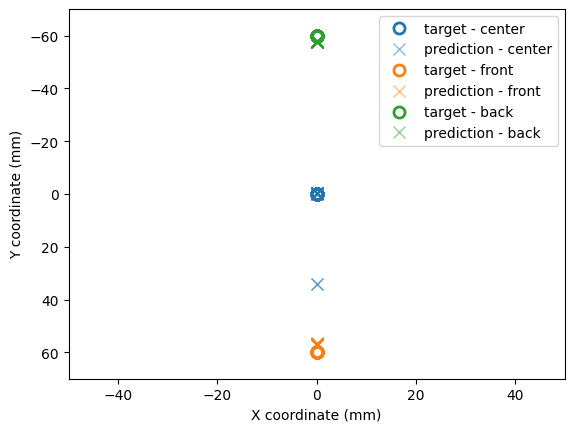

In [ ]:
from nn_helper import locations
from nn_train import test_model

fig, ax, errors = test_model(model, test_dataset, locations)

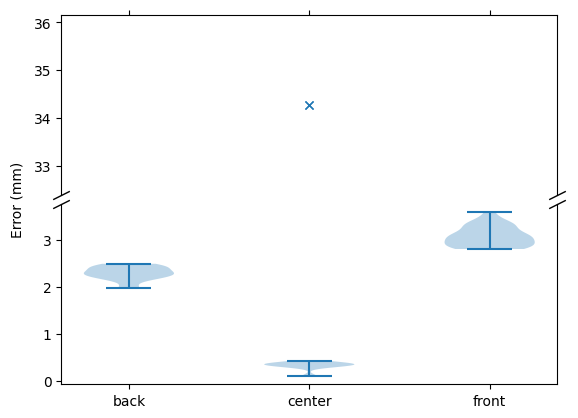

In [6]:
from nn_train import plot_violins_from_error

fig, ax = plot_violins_from_error(errors, threshold=30)